In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from jupyterthemes import jtplot
jtplot.style()
%matplotlib inline

### In this assignment, you will implement ridge regression via gradient descent. You will:
#### Convert an SFrame into a Numpy array (if applicable)
#### Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
#### Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

#### Next, from Module 2, copy and paste the ‘get_numpy_data’ function (or equivalent) that takes a dataframe, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), to be used as inputs, and a name of the output (e.g. ‘price’). This function returns a ‘feature_matrix’ (2D array) consisting of first a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It alsos return an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’).

In [28]:
def get_numpy_data(data_frame, features, output):
    """
    data_frame: pd.Dataframe
    featrues: a list of features name (e.g. [‘sqft_living’, ‘bedrooms’])
    output: a name of the output (e.g. ‘price’) 
    """
    # create a constant column with value one
    constant_column = np.ones((len(data_frame), 1))
    
    # create the features matrix
    features_matrix = np.hstack((constant_column, data_frame.as_matrix(columns=features)))
    
    # this will convert the pd.Series into a numpy array
    output_name = [output]
    # as_matrix accept list as keywords
    output_array = data_frame.as_matrix(columns=output_name)
    return features_matrix, output_array

#### Similarly, copy and paste the ‘predict_output’ function (or equivalent) from Module 2. This function accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and return a 1D array ‘predictions’.

In [4]:
def predict_output(feature_matrix, weights):
    return np.dot(feature_matrix, weights)

####  We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
#### Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Module 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be written as:

##### 2*SUM[ error * [feature_i] ] + 2*l2_penalty*w[i]
##### IMPORTANT: We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2*l2_penalty*w[0] term).

In [5]:
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [90]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # errors = predictions - output
    
    if feature_is_constant:
        # deal with the intercept, not regularize ir
        derivative = 2 * np.dot(feature, errors)
    else:
        derivative = 2 * np.dot(feature, errors) + 2 * l2_penalty * weight
    return derivative

#### Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

##### The amount by which we move in the negative gradient direction is called the ‘step size’. We stop when we are ‘sufficiently close’ to the optimum. Unlike in Module 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)
##### With this in mind, write a gradient descent function using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria. The function will take the following parameters:
###### 2D feature matrix
###### array of output values
###### initial weights
###### step size
###### L2 penalty
###### maximum number of iterations

In [118]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty, max_iterations=100):
    # make sure it's a numpy array
    weights = np.array(initial_weights).reshape(len(initial_weights), 1).astype(float) 
    
    # while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                # pay attention to weights[i]
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], 
                                                      weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], 
                                                      weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight  
            weights[i] = weights[i] - step_size * derivative
            
        max_iterations = max_iterations - 1
    return weights

In [55]:
train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)

In [56]:
simple_features = ['sqft_living']
my_output = 'price'

In [159]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

#### First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm to learn the weights of the simple model (described above). Use the following parameters:

In [167]:
step_size = 1e-12
max_iterations = 1000
initial_weights = np.array([0, 0])

In [161]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                               initial_weights, step_size, 0, max_iterations)

#### Next, let’s consider high regularization. Set the L2 penalty to 1e11 and run your ridge regression to learn the weights of the simple model. Use the same parameters as above. Call your weights:

In [162]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                               initial_weights, step_size, 1e11, max_iterations)

In [163]:
simple_weights_0_penalty

array([[-1.63113515e-01],
       [ 2.63024369e+02]])

In [164]:
simple_weights_high_penalty

array([[  9.76730382],
       [124.57217567]])

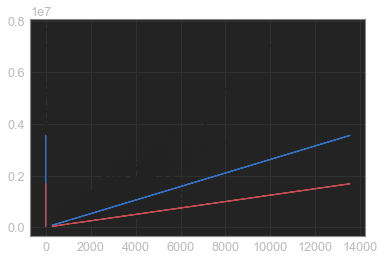

In [165]:
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [169]:
print("RSS with weights learned with no regularization: ", np.sum((test_output - 
                                      predict_output(simple_test_feature_matrix, simple_weights_0_penalty)) ** 2))

RSS with weights learned with no regularization:  275723632153607.44


#### Compute the RSS on the TEST data for the following three sets of weights:
##### The initial weights (all zeros)
##### The weights learned with no regularization
##### The weights learned with high regularization

In [170]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)
step_size = 1e-12
max_iterations = 1000
initial_weights = np.array([0, 0, 0])

In [171]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 0, max_iterations)
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 1e11, max_iterations)

In [173]:
print(multiple_weights_0_penalty)

[[ -0.35743483]
 [243.05416982]
 [ 22.41481497]]


In [174]:
print(multiple_weights_high_penalty)

[[ 6.74296579]
 [91.48927365]
 [78.43658766]]


In [151]:
print("RSS with initial_weights: ", np.sum((test_output - 
                                      predict_output(test_feature_matrix, np.array([0, 0, 0]))) ** 2))

RSS with initial_weights:  7.545691727070396e+18


In [152]:
print("RSS with weights learned with no regularization: ", np.sum((test_output - 
                                      predict_output(test_feature_matrix, multiple_weights_0_penalty)) ** 2))

RSS with weights learned with no regularization:  274067615918575.56


In [153]:
print("RSS with weights learned with high regularization: ", np.sum((test_output - 
                                      predict_output(test_feature_matrix, multiple_weights_high_penalty)) ** 2))

RSS with weights learned with high regularization:  500404800500841.75


#### Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.)

In [154]:
test_output[0] - predict_output(test_feature_matrix, multiple_weights_0_penalty)[0]

array([-77465.47605824])

In [155]:
test_output[0] - predict_output(test_feature_matrix, multiple_weights_high_penalty)[0]

array([39546.46967806])